# Importing the required libraries

In [3]:
#Importing libraries
import os
import SimpleITK as sitk
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from scipy import ndimage

In [4]:
#Importing dependencies from files
from data_loading import loadcase, loadlm   #To load the data
from utils import plot_slices, basic_plot, basic_plot_def, basic_plot_lm   #To make the plots
from terminal import run_command, run_command2, get_def_field  #To call elastix and transformix
from get_masks import get_crop_mask, get_lungs_volume   #To get the masks (cropped and lungs)

# Initialization of main directories and information (pixel spacing, Scan ID)

In [18]:
#Specifying the path where both the Nifti and lanmark files are
#And the parameters file
data_folder = 'data_original'
params_aff = 'params/affine_transform.txt'
params_nr = 'params/bspline_transform.txt'

pixel_spacing = [[0.625, 0.625, 2.5],
                [0.645, 0.645, 2.5],
                [0.652, 0.652, 2.5],
                [0.590, 0.590, 2.5]]
scan_id = ['COPD1', 'COPD2', 'COPD3', 'COPD4',]

data_original/copd1_eBHCT.nii.gz data_original/copd1_iBHCT.nii.gz
data_original/copd1_300_eBH_xyz_r1.txt data_original/copd1_300_iBH_xyz_r1.txt


# I. Transformation Test

In [ ]:
#Empty lists to store TRE results
ls_tre_or = []
ls_tre_aff = []
ls_tre_nr = []
ls_tre_aff_nr = []
ls_tre_aff_nr_inv = []

#Loop over the 4 COPD volumes
for i in range(1,5):
    #Loading the paths of the data
    vol_e, vol_i = loadcase(data_folder, i)
    lm_e, lm_i = loadlm(data_folder, i)

    #Getting the Arrray from the landmarks file
    lm_ee = np.genfromtxt(lm_e).astype(np.int64)
    lm_ii = np.genfromtxt(lm_i).astype(np.int64)
    #Calculating TRE before registration
    tre_or = (np.sum(((lm_ee - lm_ii)*pixel_spacing[i-1])**2, 1)**0.5)

    #Running the registrations
    run_command(vol_e, vol_i, 'results_aff/', [params_aff])
    run_command(vol_e, vol_i, 'results_nr/', [params_nr])
    run_command(vol_e, vol_i, 'results_aff_nr/', [params_aff, params_nr])
    run_command(vol_e, vol_i, 'results_aff_nr_inverted/', [params_nr, params_aff])

    #Changing the inhale landmarks file to be understood by transformix
    with open(lm_i,'r') as f:
        with open('newfile.txt','w') as f2: 
            f2.write('index\n300\n')
            f2.write(f.read())
    
    #Calling transformix, getting the transformed points and calculating TRE for each case
    command = 'transformix -def newfile.txt -out ./results -tp ./results_aff/TransformParameters.0.txt'
    os.system(command)
    new_points_aff = np.genfromtxt('results/outputpoints.txt', dtype=np.int64)[:,22:25]
    tre_aff = (np.sum(((lm_ee - new_points_aff)*pixel_spacing[i-1])**2, 1)**0.5)

    command = 'transformix -def newfile.txt -out ./results -tp ./results_nr/TransformParameters.0.txt'
    os.system(command)
    new_points_nr = np.genfromtxt('results/outputpoints.txt', dtype=np.int64)[:,22:25]
    tre_nr = (np.sum(((lm_ee - new_points_nr)*pixel_spacing[i-1])**2, 1)**0.5)

    command = 'transformix -def newfile.txt -out ./results -tp ./results_aff_nr/TransformParameters.1.txt'
    os.system(command)
    new_points_aff_nr = np.genfromtxt('results/outputpoints.txt', dtype=np.int64)[:,22:25]
    tre_aff_nr = (np.sum(((lm_ee - new_points_aff_nr)*pixel_spacing[i-1])**2, 1)**0.5)

    command = 'transformix -def newfile.txt -out ./results -tp ./results_aff_nr_inverted/TransformParameters.1.txt'
    os.system(command)
    new_points_aff_nr_inv = np.genfromtxt('results/outputpoints.txt', dtype=np.int64)[:,22:25]
    tre_aff_nr_inv = (np.sum(((lm_ee - new_points_aff_nr_inv)*pixel_spacing[i-1])**2, 1)**0.5)

    #Getting the TRE results for each case as mean (std)
    ls_tre_or.append("{0:.4f} ({1:.4f})".format(np.mean(tre_or), np.std(tre_or)))
    ls_tre_aff.append("{0:.4f} ({1:.4f})".format(np.mean(tre_aff), np.std(tre_aff)))
    ls_tre_nr.append("{0:.4f} ({1:.4f})".format(np.mean(tre_nr), np.std(tre_nr))),
    ls_tre_aff_nr.append("{0:.4f} ({1:.4f})".format(np.mean(tre_aff_nr), np.std(tre_aff_nr)))
    ls_tre_aff_nr_inv.append("{0:.4f} ({1:.4f})".format(np.mean(tre_aff_nr_inv), np.std(tre_aff_nr_inv)))

#Putting everything in a dataframe
metrics_df = {'Scan ID': scan_id, 'TRE Original': ls_tre_or, 'TRE Affine': ls_tre_aff, 'TRE NR': ls_tre_nr, 'TRE Affine + NR': ls_tre_aff_nr, 'TRE Affine + NR (inv)': ls_tre_aff_nr_inv}
m = pd.DataFrame(metrics_df)

In [ ]:
#Getting the deformation fields to make the plot
get_def_field('results_aff')
get_def_field('results_nr')
get_def_field('results_aff_nr',compose=True)
get_def_field('results_aff_nr_inverted', compose=True)

# I. Plot results

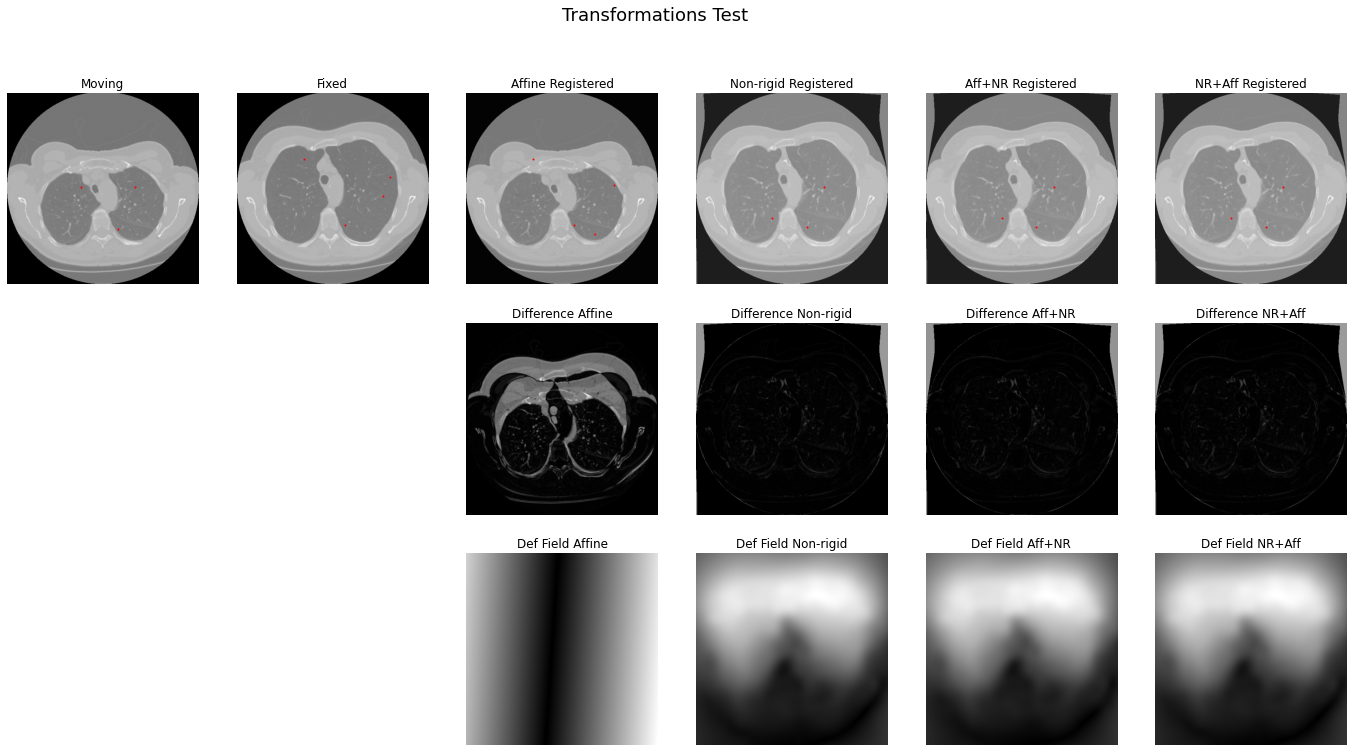

In [72]:
#Getting the volumes to plot
vol_ee = sitk.GetArrayFromImage(sitk.ReadImage(vol_e)) - 1000
vol_ii = sitk.GetArrayFromImage(sitk.ReadImage(vol_i)) - 1000
vol_reg_aff = sitk.GetArrayFromImage(sitk.ReadImage('results_aff/result.0.nii.gz')) - 1000
vol_reg_nr = sitk.GetArrayFromImage(sitk.ReadImage('results_nr/result.0.nii.gz')) - 1000
vol_reg_aff_nr = sitk.GetArrayFromImage(sitk.ReadImage('results_aff_nr/result.1.nii.gz')) - 1000
vol_reg_aff_nr_inv = sitk.GetArrayFromImage(sitk.ReadImage('results_aff_nr_inverted/result.1.nii.gz')) - 1000

#Select slice and make the plot
slice = 32
fig = plt.figure(1, figsize=(6*4,3*4))
plt.clf()
plt.suptitle('Transformations Test',fontsize=18)
plt.subplot(361); basic_plot_lm(vol_ee, slice, 'Moving', lm_ee)
plt.subplot(362); basic_plot_lm(vol_ii, slice, 'Fixed', lm_ii)
plt.subplot(363); basic_plot_lm(vol_reg_aff, slice, 'Affine Registered', new_points_aff)
plt.subplot(364); basic_plot_lm(vol_reg_nr, slice, 'Non-rigid Registered', new_points_nr)
plt.subplot(365); basic_plot_lm(vol_reg_aff_nr, slice, 'Aff+NR Registered', new_points_aff_nr)
plt.subplot(366); basic_plot_lm(vol_reg_aff_nr_inv, slice, 'NR+Aff Registered', new_points_aff_nr_inv)

plt.subplot(3,6,9); basic_plot(np.abs(vol_ii-vol_reg_aff), slice, 'Difference Affine')
plt.subplot(3,6,10); basic_plot(np.abs(vol_ii-vol_reg_nr), slice, 'Difference Non-rigid')
plt.subplot(3,6,11); basic_plot(np.abs(vol_ii-vol_reg_aff_nr), slice, 'Difference Aff+NR')
plt.subplot(3,6,12); basic_plot(np.abs(vol_ii-vol_reg_aff_nr_inv), slice, 'Difference NR+Aff')

plt.subplot(3,6,15); basic_plot_def('results_aff', slice, 'Def Field Affine')
plt.subplot(3,6,16); basic_plot_def('results_nr', slice, 'Def Field Non-rigid')
plt.subplot(3,6,17); basic_plot_def('results_aff_nr', slice, 'Def Field Aff+NR')
plt.subplot(3,6,18); basic_plot_def('results_aff_nr_inverted', slice, 'Def Field NR+Aff')

# II. Obtaining both crop and lungs mask

In [ ]:
#Iterate over the 4 volumes
for i in range(1,5):
    #Read and load the volumes and landmarks into arrays
    vol_e, vol_i = loadcase('data_folder', i)
    vol_ee = sitk.GetArrayFromImage(sitk.ReadImage(vol_e)) - 1000
    vol_ii = sitk.GetArrayFromImage(sitk.ReadImage(vol_i)) - 1000

    lm_e, lm_i = loadlm(data_folder, i)

    #Get the cropped masks and convert them to SITK Images
    mask_e = sitk.GetImageFromArray(get_crop_mask(vol_ee, lm_e))
    mask_i = sitk.GetImageFromArray(get_crop_mask(vol_ii, lm_i))

    #Include header indormation of the original file (Voxel spacing,...)
    mask_e.CopyInformation(sitk.ReadImage(vol_e))
    mask_i.CopyInformation(sitk.ReadImage(vol_i))

    #Write the cropped masks into files
    sitk.WriteImage(mask_e, 'masks_crop/'+os.path.basename(vol_e)[:10]+'_maskcrop.nii.gz')
    sitk.WriteImage(mask_i, 'masks_crop/'+os.path.basename(vol_i)[:10]+'_maskcrop.nii.gz')

    #Get the lungs masks and convert them to SITK Images
    mask_e = sitk.GetImageFromArray(get_lungs_volume(vol_ee))
    mask_i = sitk.GetImageFromArray(get_lungs_volume(vol_ii))

    #Include header indormation of the original file (Voxel spacing,...)
    mask_e.CopyInformation(sitk.ReadImage(vol_e))
    mask_i.CopyInformation(sitk.ReadImage(vol_i))
    
    #Write the lung masks into files
    sitk.WriteImage(mask_e, 'masks_lung/'+os.path.basename(vol_e)[:10]+'_masklung.nii.gz')
    sitk.WriteImage(mask_i, 'masks_lung/'+os.path.basename(vol_i)[:10]+'_masklung.nii.gz')

# II. Obtaining the modified volumes (Normalized, Sobel and Laplacian)

In [ ]:
#Iterate over the 4 volumes
for i in range(1,5):
    #Read and load the volumes, lungs masks and landmarks into arrays
    vol_e, vol_i = loadcase(data_folder, i)
    vol_ee = sitk.GetArrayFromImage(sitk.ReadImage(vol_e)) - 1000
    vol_ii = sitk.GetArrayFromImage(sitk.ReadImage(vol_i)) - 1000
    lungs_e, lungs_i = loadcase('masks_lung', i)
    lungs_ee = sitk.GetArrayFromImage(sitk.ReadImage(lungs_e))
    lungs_ii = sitk.GetArrayFromImage(sitk.ReadImage(lungs_i))

    #1st process the exhale volume

    #Create empty arrays of the output volumes
    vol_norm = np.zeros(vol_ee.shape)
    vol_grad1 = np.zeros(vol_ee.shape)
    vol_grad2 = np.zeros(vol_ee.shape)

    #Iterate over the z-dimension and transform slice by slice
    for i in range(vol_ee.shape[0]):
        im = lungs_ee[i,:,:]*vol_ee[i,:,:]
        #If there is no lung mask in that slice, keep 0s
        if np.sum(np.sum(im))==0:
            pass
        else:
            vol_norm[i,:,:] = (im-np.min(im))/(np.max(im)-np.min(im))
            vol_grad1[i,:,:] = np.abs(ndimage.sobel(im))
            vol_grad2[i,:,:] = np.abs(ndimage.laplace(im))

    #Transform the arrays to SITK Images
    vol_norm = sitk.GetImageFromArray(vol_norm)
    vol_grad1 = sitk.GetImageFromArray(vol_grad1)
    vol_grad2 = sitk.GetImageFromArray(vol_grad2)

    #Include header indormation of the original file (Voxel spacing,...)
    vol_norm.CopyInformation(sitk.ReadImage(vol_e))
    vol_grad1.CopyInformation(sitk.ReadImage(vol_e))
    vol_grad2.CopyInformation(sitk.ReadImage(vol_e))

    #Write the results into files
    sitk.WriteImage(vol_norm, 'data_norm/'+os.path.basename(vol_e)[:10]+'_norm.nii.gz')
    sitk.WriteImage(vol_grad1, 'data_grad1/'+os.path.basename(vol_e)[:10]+'_grad1.nii.gz')
    sitk.WriteImage(vol_grad2, 'data_grad2/'+os.path.basename(vol_e)[:10]+'_grad2.nii.gz')

    #2nd. Repeat the process for the inhale volume

    vol_norm = np.zeros(vol_ii.shape)
    vol_grad1 = np.zeros(vol_ii.shape)
    vol_grad2 = np.zeros(vol_ii.shape)

    for i in range(vol_ii.shape[0]):
        im = lungs_ii[i,:,:]*vol_ii[i,:,:]
        if np.sum(np.sum(im))==0:
            pass
        else:
            vol_norm[i,:,:] = (im-np.min(im))/(np.max(im)-np.min(im))
            vol_grad1[i,:,:] = np.abs(ndimage.sobel(im))
            vol_grad2[i,:,:] = np.abs(ndimage.laplace(im))

    vol_norm = sitk.GetImageFromArray(vol_norm)
    vol_grad1 = sitk.GetImageFromArray(vol_grad1)
    vol_grad2 = sitk.GetImageFromArray(vol_grad2)

    vol_norm.CopyInformation(sitk.ReadImage(vol_i))
    vol_grad1.CopyInformation(sitk.ReadImage(vol_i))
    vol_grad2.CopyInformation(sitk.ReadImage(vol_i))

    sitk.WriteImage(vol_norm, 'data_norm/'+os.path.basename(vol_i)[:10]+'_norm.nii.gz')
    sitk.WriteImage(vol_grad1, 'data_grad1/'+os.path.basename(vol_i)[:10]+'_grad1.nii.gz')
    sitk.WriteImage(vol_grad2, 'data_grad2/'+os.path.basename(vol_i)[:10]+'_grad2.nii.gz')


data_original/copd1_eBHCT.nii.gz data_original/copd1_iBHCT.nii.gz


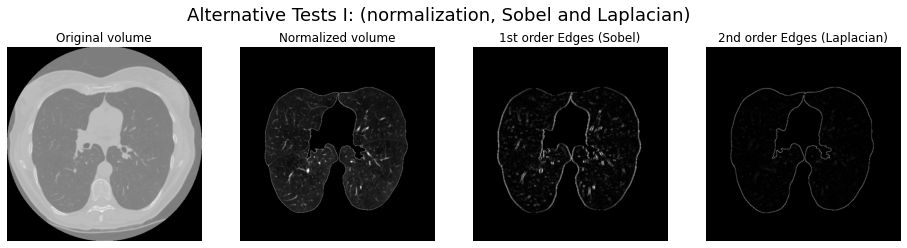

In [10]:
#Check the processed volumes
vol_ii = sitk.GetArrayFromImage(sitk.ReadImage(loadcase('data_original/',1)[1])) - 1000
vol_norm = sitk.GetArrayFromImage(sitk.ReadImage('data_norm/copd1_iBHC_norm.nii.gz'))
vol_grad1 = sitk.GetArrayFromImage(sitk.ReadImage('data_grad1/copd1_iBHC_grad1.nii.gz'))
vol_grad2 = sitk.GetArrayFromImage(sitk.ReadImage('data_grad2/copd1_iBHC_grad2.nii.gz'))

slice = 60
fig = plt.figure(1, figsize=(4*4,1*4))
plt.clf()
plt.suptitle('Alternative Tests I: (normalization, Sobel and Laplacian)',fontsize=18)
plt.subplot(141); basic_plot(vol_ii, slice, 'Original volume')
plt.subplot(142); basic_plot(vol_norm, slice, 'Normalized volume')
plt.subplot(143); basic_plot(vol_grad1, slice, '1st order Edges (Sobel)')
plt.subplot(144); basic_plot(vol_grad2, slice, '2nd order Edges (Laplacian)')

# II. Masks tests (Cropped, Lung) and Alternative Test (Normalized, Sobel and Laplace images)

In [ ]:
#Empty lists to store TRE results
ls_tre_or = []
ls_tre_nr_crop = []
ls_tre_nr_lung = []
ls_tre_nr_norm = []
ls_tre_nr_grad1 = []
ls_tre_nr_grad2 = []

#Loop over the 4 COPD volumes
for i in range(1,5):
    #Loading the paths of the data
    vol_e, vol_i = loadcase(data_folder, i)
    lm_e, lm_i = loadlm(data_folder, i)

    #Getting the Arrray from the landmarks file
    lm_ee = np.genfromtxt(lm_e).astype(np.int64)
    lm_ii = np.genfromtxt(lm_i).astype(np.int64)
    #Calculating TRE before registration
    tre_or = (np.sum(((lm_ee - lm_ii)*pixel_spacing[i-1])**2, 1)**0.5)

    #Getting the masks
    mask_e_crop, mask_i_crop = loadcase('masks_crop', i)
    mask_e_lung, mask_i_lung = loadcase('masks_lung', i)

    #Getting the modified volumes
    vol_e_norm, vol_i_norm = loadcase('data_norm', i)
    vol_e_grad1, vol_i_grad1 = loadcase('data_grad1', i)
    vol_e_grad2, vol_i_grad2 = loadcase('data_grad2', i)

    #Running the registrations
    run_command2(vol_e, vol_i, 'results_aff_nr_crop/', [params_aff, params_nr], mask_e_crop, mask_i_crop)
    run_command2(vol_e, vol_i, 'results_aff_nr_lung/', [params_aff, params_nr], mask_e_lung, mask_i_lung)
    run_command2(vol_e_norm, vol_i_norm, 'results_aff_nr_norm/', [params_aff, params_nr], mask_e_lung, mask_i_lung)
    run_command2(vol_e_grad1, vol_i_grad1, 'results_aff_nr_grad1/', [params_aff, params_nr], mask_e_lung, mask_i_lung)
    run_command2(vol_e_grad2, vol_i_grad2, 'results_aff_nr_grad2/', [params_aff, params_nr], mask_e_lung, mask_i_lung)
    
    #Changing the inhale landmarks file to be understood by transformix    
    with open(lm_i,'r') as f:
        with open('newfile.txt','w') as f2: 
            f2.write('index\n300\n')
            f2.write(f.read())

    #Calling transformix, getting the transformed points and calculating TRE for each case           
    command = 'transformix -def newfile.txt -out ./results -tp ./results_aff_nr_crop/TransformParameters.1.txt'
    os.system(command)
    new_points_crop = np.genfromtxt('results/outputpoints.txt', dtype=np.int64)[:,22:25]
    tre_nr_crop = (np.sum(((lm_ee - new_points_crop)*pixel_spacing[i-1])**2, 1)**0.5)

    command = 'transformix -def newfile.txt -out ./results -tp ./results_aff_nr_lung/TransformParameters.1.txt'
    os.system(command)
    new_points_lung = np.genfromtxt('results/outputpoints.txt', dtype=np.int64)[:,22:25]
    tre_nr_lung = (np.sum(((lm_ee - new_points_lung)*pixel_spacing[i-1])**2, 1)**0.5)

    command = 'transformix -def newfile.txt -out ./results -tp ./results_aff_nr_norm/TransformParameters.1.txt'
    os.system(command)
    new_points_norm = np.genfromtxt('results/outputpoints.txt', dtype=np.int64)[:,22:25]
    tre_nr_norm = (np.sum(((lm_ee - new_points_norm)*pixel_spacing[i-1])**2, 1)**0.5)

    command = 'transformix -def newfile.txt -out ./results -tp ./results_aff_nr_grad1/TransformParameters.1.txt'
    os.system(command)
    new_points_grad1 = np.genfromtxt('results/outputpoints.txt', dtype=np.int64)[:,22:25]
    tre_nr_grad1 = (np.sum(((lm_ee - new_points_grad1)*pixel_spacing[i-1])**2, 1)**0.5)

    command = 'transformix -def newfile.txt -out ./results -tp ./results_aff_nr_grad2/TransformParameters.1.txt'
    os.system(command)
    new_points_grad2 = np.genfromtxt('results/outputpoints.txt', dtype=np.int64)[:,22:25]
    tre_nr_grad2 = (np.sum(((lm_ee - new_points_grad2)*pixel_spacing[i-1])**2, 1)**0.5)

    #Getting the TRE results for each case as mean (std)
    ls_tre_or.append("{0:.4f} ({1:.4f})".format(np.mean(tre_or), np.std(tre_or)))
    ls_tre_nr_crop.append("{0:.4f} ({1:.4f})".format(np.mean(tre_nr_crop), np.std(tre_nr_crop)))
    ls_tre_nr_lung.append("{0:.4f} ({1:.4f})".format(np.mean(tre_nr_lung), np.std(tre_nr_lung)))
    ls_tre_nr_norm.append("{0:.4f} ({1:.4f})".format(np.mean(tre_nr_norm), np.std(tre_nr_norm)))
    ls_tre_nr_grad1.append("{0:.4f} ({1:.4f})".format(np.mean(tre_nr_grad1), np.std(tre_nr_grad1)))
    ls_tre_nr_grad2.append("{0:.4f} ({1:.4f})".format(np.mean(tre_nr_grad2), np.std(tre_nr_grad2)))

#Putting everything in a dataframe
metrics_df = {'Scan ID': scan_id, 'TRE Original': ls_tre_or, 'TRE Affine + NR Crop': ls_tre_nr_crop, 'TRE Affine + NR Lung': ls_tre_nr_lung, 'TRE Affine + NR Norm': ls_tre_nr_norm, 'TRE Affine + NR Grad1': ls_tre_nr_grad1, 'TRE Affine + NR Grad2': ls_tre_nr_grad2}
m = pd.DataFrame(metrics_df)

# II. Plot results

In [ ]:
vol_ee = sitk.GetArrayFromImage(sitk.ReadImage(loadcase('data_original/',1)[0])) - 1000
vol_ii = sitk.GetArrayFromImage(sitk.ReadImage(loadcase('data_original/',1)[1])) - 1000
vol_reg_lung = sitk.GetArrayFromImage(sitk.ReadImage('results_aff_nr_lung/result.1.nii.gz')) - 1000
vol_reg_crop = sitk.GetArrayFromImage(sitk.ReadImage('results_aff_nr_crop/result.1.nii.gz')) - 1000

lm_ee = np.genfromtxt(loadlm('data_original/',1)[0]).astype(np.int64)
lm_ii = np.genfromtxt(loadlm('data_original/',1)[1]).astype(np.int64)

slice = 60
fig = plt.figure(1, figsize=(4*4,3*4))
plt.clf()
plt.suptitle('Affine + Non-rigid Masks Test',fontsize=18)
plt.subplot(341); basic_plot_lm(vol_ee, slice, 'Moving', lm_ee)
plt.subplot(342); basic_plot_lm(vol_ii, slice, 'Fixed', lm_ii)
plt.subplot(343); basic_plot_lm(vol_reg_crop, slice, 'Crop Mask', new_points_crop)
plt.subplot(344); basic_plot_lm(vol_reg_lung, slice, 'Lung Mask', new_points_lung)

plt.subplot(3,4,7); basic_plot(np.abs(vol_ii-vol_reg_crop), slice, 'Difference Crop Mask')
plt.subplot(3,4,8); basic_plot(np.abs(vol_ii-vol_reg_lung), slice, 'Difference Lung Mask')

plt.subplot(3,4,11); basic_plot_def('results_aff_nr_crop', slice, 'Def Field Crop Mask')
plt.subplot(3,4,12); basic_plot_def('results_aff_nr_lung', slice, 'Def Field Lung Mask')